In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import pyproj
from matplotlib.collections import PatchCollection
from descartes.patch import PolygonPatch
from pyproj import Proj, transform

from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape
import fiona
from fiona.crs import to_string

from itertools import chain

import urllib

import geopandas as gpd

Import habitat model coverage

In [29]:
with fiona.open('data/HabModelEnviro.shp') as shp:
    
    records = list(shp)
    hab_model_bounds = shp.bounds
    hab_model_json = {"type": "FeatureCollection", "features": records}
    hab_model_crs = shp.crs

/usr/local/lib/python3.4/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: Read cursor may be altered. This can lead to side effects


In [4]:
epsg26717_str = urllib.request.urlopen('http://spatialreference.org/ref/epsg/26717/proj4/').read().decode("utf-8")
epsg26717_str

'+proj=utm +zone=17 +ellps=clrk66 +datum=NAD27 +units=m +no_defs '

In [31]:
wgs84 = Proj(init='EPSG:4326')

In [30]:
hab_model_proj = Proj(hab_model_crs)

In [7]:
ll = hab_model_bounds[0], hab_model_bounds[1]
ur = hab_model_bounds[2], hab_model_bounds[3]
coords = list(chain(ll, ur))

# Convert to WGS84
coords_wgs = epsg26717(*coords[:2], inverse=True) + hab_model_proj(*coords[2:], inverse=True)
w, h = coords_wgs[2] - coords_wgs[0], coords_wgs[3] - coords_wgs[1]

In [34]:
extra = 0.01

southeast = Basemap(ax=None,
    llcrnrlon=coords_wgs[0] - extra * w,
    llcrnrlat=coords_wgs[1] - extra + 0.01 * h,
    urcrnrlon=coords_wgs[2] + extra * w,
    urcrnrlat=coords_wgs[3] + extra + 0.01 * h,
    resolution='i',
    epsg='4326')

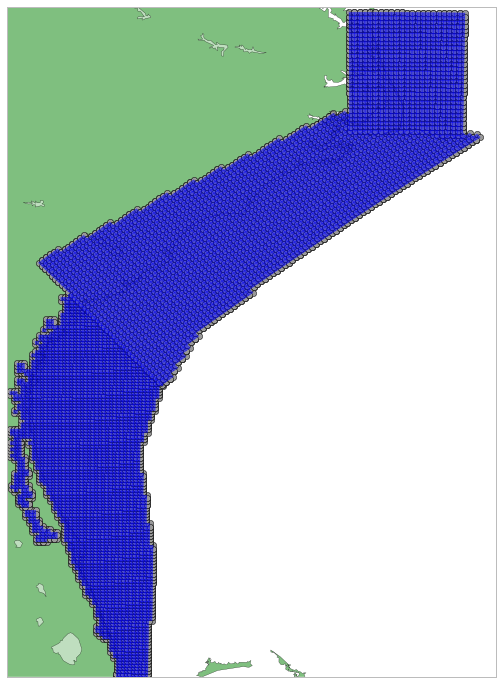

In [47]:
from matplotlib.pyplot import cm, colorbar
#from mpl_toolkits.basemap import Polygon, PolyCollection

fig = plt.figure(figsize=(16,12))
ax = plt.gca()
southeast.drawcoastlines(linewidth=0.25)
southeast.fillcontinents(zorder=-1, color='green', alpha=0.5)

mp = MultiPolygon(
    [shape(pol['geometry']) for pol in fiona.open('data/HabModelEnviro_WGS84.shp')])

# patches = []
# for poly in mp:
#     #colour = cm(1. * len(filter(poly.contains, points)) / num_colours)
#     patches.append(PolygonPatch(poly, fc=colour, ec='#555555', lw=0.2, alpha=1., zorder=1))
# pc = PatchCollection(patches, match_original=True)
# ax.add_collection(pc)

def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, 'o', color='#999999', zorder=1)
    
for polygon in mp:
    plot_coords(ax, polygon.exterior)
    patch = PolygonPatch(polygon, facecolor='blue', edgecolor='blue', alpha=0.5, zorder=2)
    ax.add_patch(patch)

# z = [state_cases[i]*(i!='SAO PAULO') for i in municipio]
# coll = PolyCollection(SP_region.region, array=np.array(z), cmap=cm.Blues, edgecolors='none')
# ax.add_patch(mp)
# colorbar(coll, ax=ax, shrink=0.7)

# sp_poly = Polygon(SP_region.region[municipio.index('SAO PAULO')], facecolor='black')
# ax.add_patch(sp_poly)


plt.show()

Import data to GeoPandas

In [48]:
HabModelEnviro = gpd.GeoDataFrame.from_file('data/HabModelEnviro.shp').replace({-999: None})

In [49]:
urllib.request.urlopen('http://spatialreference.org/ref/epsg/4326/proj4/').read().decode("utf-8")

'+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs '

In [50]:
HabModelEnviroWGS84 = HabModelEnviro.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'})

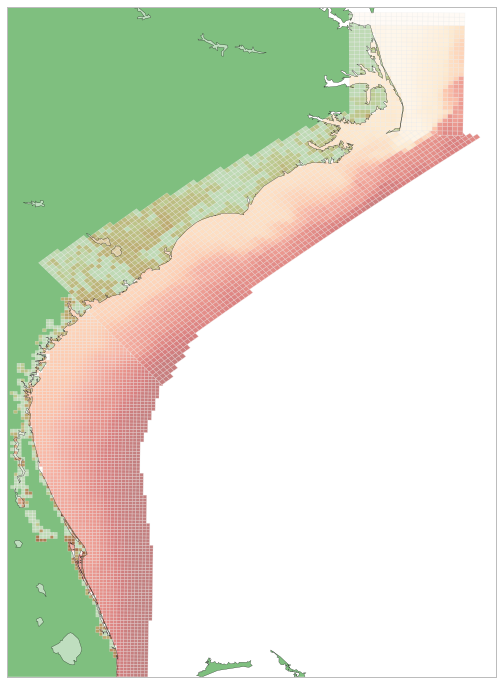

In [58]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
southeast.drawcoastlines(linewidth=0.25)
southeast.fillcontinents(zorder=-1, color='green', alpha=0.5)

HabModelEnviroWGS84.plot(column='sstmar13b', k=5, colormap='OrRd', linewidth=0, axes=ax)

In [59]:
HabModelSurvey = gpd.GeoDataFrame.from_file('data/HabModelSurvey.shp')

In [62]:
HabModelSurveyWGS84 = HabModelSurvey.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'})

In [69]:
HabModelSurveyWGS84.GrpsJan10B.value_counts()

0    5576
1      45
2      12
3       4
4       2
7       1
6       1
5       1
dtype: int64

Colormap for binary features

In [81]:
import matplotlib
binary_cm = matplotlib.colors.ListedColormap(np.array([[255,255,255], [0,0,0]])/255)

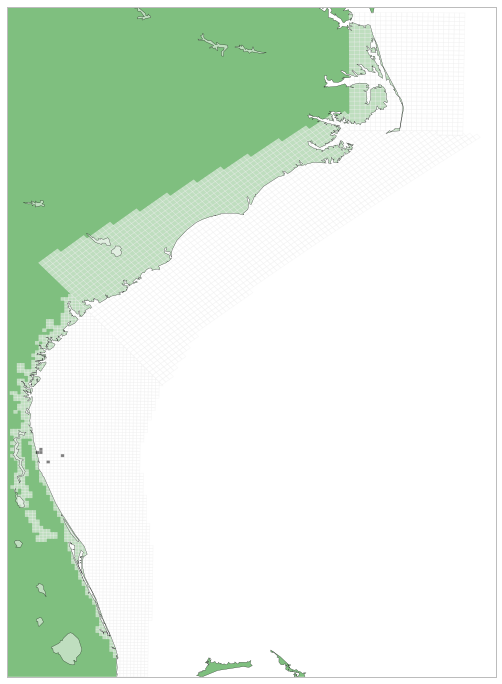

In [82]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
southeast.drawcoastlines(linewidth=0.25)
southeast.fillcontinents(zorder=-1, color='green', alpha=0.5)

HabModelSurveyWGS84.plot(column='GrpsJan10B', k=2, colormap=binary_cm, linewidth=0, axes=ax)

SST and whales for an arbitrary month

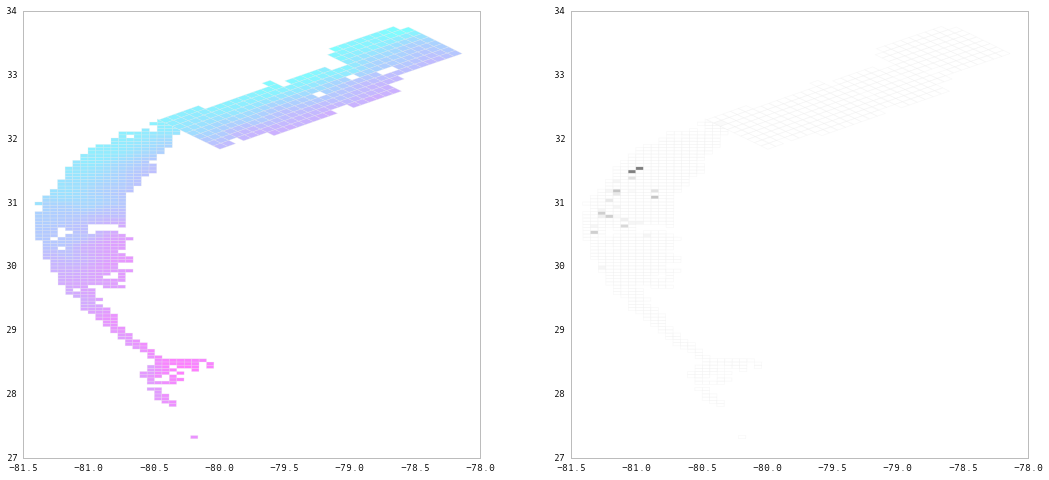

In [117]:
f, axes = plt.subplots(1, 2, figsize=(18, 8))

HabModel_merged.dropna().plot(column='sstjan12b', k=8, colormap='cool', linewidth=0, axes=axes[0])

HabModel_merged.dropna().plot(column='WhlsJan12b', k=3, colormap='Greys', linewidth=0, axes=axes[1])


Perform a merge of survey and habitat data

In [128]:
# Use lower case for trailing A and B times
replace_dict = {c:c[:-1]+c[-1].lower() for c in HabModelEnviro_points.columns if c.endswith('A') or c.endswith('B')}
HabModelEnviro_points = HabModelEnviroWGS84.copy().rename(columns=replace_dict)
HabModelEnviro_points.geometry = HabModelEnviro_points.geometry.centroid

In [134]:
from geopandas.tools import sjoin

replace_dict = {c:c[:-1]+c[-1].lower() for c in HabModelSurveyWGS84.columns if c.endswith('A') or c.endswith('B')}
HabModel_merged = sjoin(HabModelSurveyWGS84.rename(columns=replace_dict), HabModelEnviro_points, how="left")

In [135]:
HabModel_merged.shape

(5642, 418)

In [136]:
HabModel_merged.head()

,EffDec03a,EffDec03b,EffDec04a,EffDec04b,EffDec05a,EffDec05b,EffDec06a,EffDec06b,EffDec07a,EffDec07b,...,sstmar09a,sstmar09b,sstmar10a,sstmar10b,sstmar11a,sstmar11b,sstmar12a,sstmar12b,sstmar13a,sstmar13b
0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.910000,NaN,17.952084
1,0,0,0,0,0,0,0,0,0,0,...,23.060,NaN,21.047,23.362,24.143,24.052,24.953751,25.335714,23.437042,23.296764
2,0,0,0,0,0,0,0,0,0,0,...,24.634,NaN,21.723,23.264,24.469,24.363,25.340000,25.974688,23.528656,23.534910
3,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,23.098,23.529,24.918,24.710,25.998001,26.516251,23.761000,23.787819
4,0,0,0,0,0,0,0,0,0,0,...,24.720,NaN,23.696,23.597,24.967,24.920,26.090000,26.667604,24.145739,23.980265


Convert data into long format and remove time information from column names. We are breaking the data into one table for each 2-week period.

In [146]:
time_intervals = ['Dec03a','Dec03b','Dec04a','Dec04b','Dec05a','Dec05b','Dec06a','Dec06b','Dec07a','Dec07b',
         'Dec08a','Dec08b','Dec09a','Dec09b','Dec10a','Dec10b','Dec11a','Dec11b','Dec12a','Dec12b',
         'Feb04a','Feb04b','Feb05a','Feb05b','Feb06a','Feb06b','Feb07a','Feb07b','Feb08a','Feb08b',
         'Feb09a','Feb09b','Feb10a','Feb10b','Feb11a','Feb11b','Feb12a','Feb12b','Feb13a','Feb13b',
         'Jan04a','Jan04b','Jan05a','Jan05b','Jan06a','Jan06b','Jan07a','Jan07b','Jan08a','Jan08b',
         'Jan09a','Jan09b','Jan10a','Jan10b','Jan11a','Jan11b','Jan12a','Jan12b','Jan13a','Jan13b',
         'Mar04a','Mar04b','Mar05a','Mar05b','Mar06a','Mar06b','Mar07a','Mar07b','Mar08a','Mar08b',
         'Mar09a','Mar09b','Mar10a','Mar10b','Mar11a','Mar11b','Mar12a','Mar12b','Mar13a','Mar13b']

data_types = ['Eff', 'Grps', 'Whls', 'iso', 'sst']

In [169]:
months = {'Dec':0, 'Jan':1, 'Feb':2, 'Mar':3}
fortnights = {'a':0, 'b':1}

In [178]:
working_dataset = HabModel_merged.reset_index(level=0).rename(columns={'index':'quad_id'})

bimonthly_subsets = []
for t in time_intervals:
    # Build column name list
    cols = ['quad_id', 'geometry', 'DistToShor']
    cols += [d+t for d in data_types[:-2]]
    cols += [d+t.lower() for d in data_types[-2:]]
    
    # Remove year time data from column labels
    subset = working_dataset[cols].rename(columns=dict(zip(cols[3:], data_types)))
    
    # Add time data
    month = months[t[:3]]
    year = int(t[3:-1])
    fortnight = fortnights[t[-1]]
    period = month*2 + fortnight
    
    subset['period'] = period
    subset['year'] = year - 3
    subset['time'] = t
    
    bimonthly_subsets.append(subset)

Concatenate subsets into single dataset

In [180]:
working_data_long = pd.concat(bimonthly_subsets, ignore_index=True)

Confirm that the resulting dataset is the same shape

In [184]:
assert sum([b.shape[0] for b in bimonthly_subsets]) == working_data_long.shape[0]